In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
import config
import metrics
import implementations


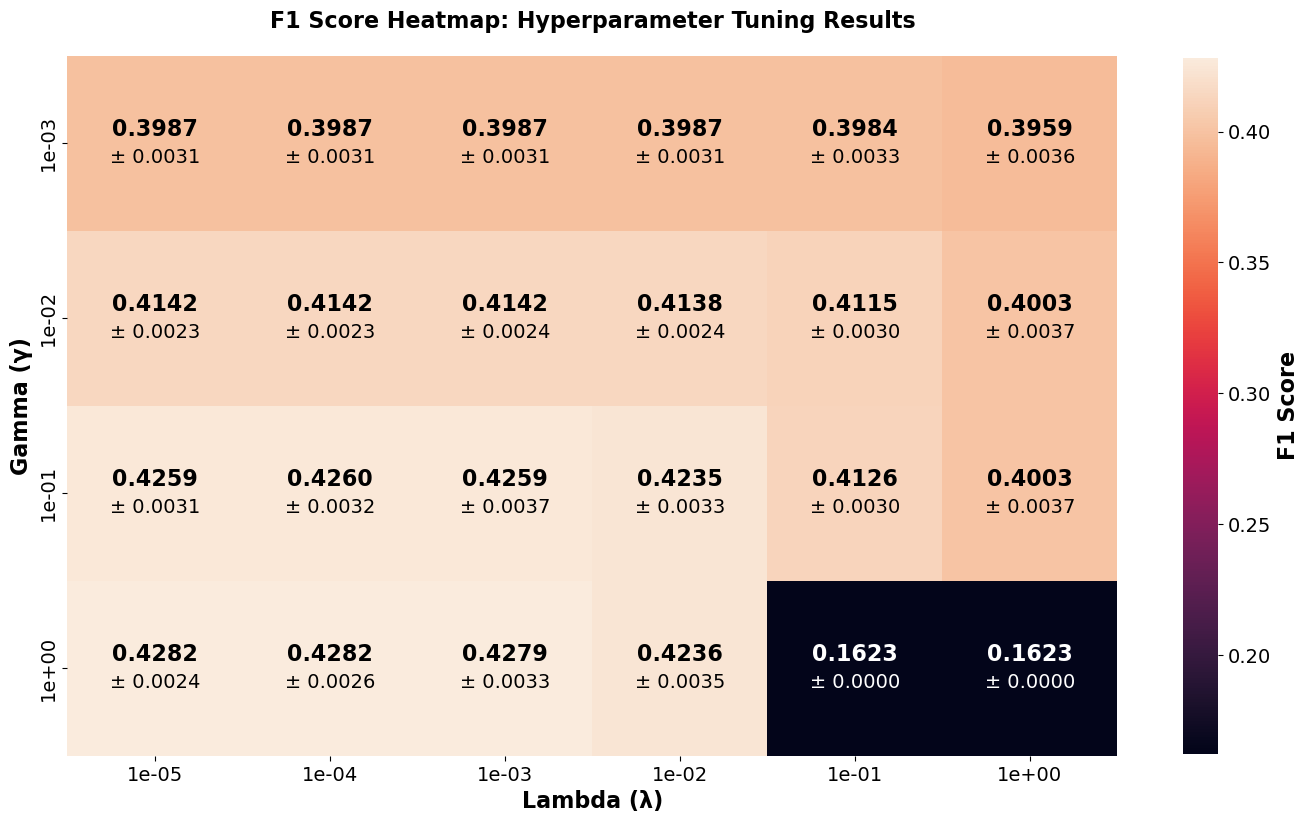


Best Configuration:
  Lambda: 1e-04
  Gamma: 1e+00
  F1 Score: 0.4282 ± 0.0026


In [2]:
#heatmap: lambda vs gamma

# Load the tuning results
csv_path = '../data_saving/tuning_2.csv'
data = []
with open(csv_path, 'r') as f:
    lines = f.readlines()
    header = lines[0].strip().split(',')
    for line in lines[1:]:
        values = line.strip().split(',')
        data.append(dict(zip(header, values)))

# Extract unique lambda and gamma values
lambdas = sorted(list(set([float(d['lambda']) for d in data])))
gammas = sorted(list(set([float(d['gamma']) for d in data])))

# Create matrices for F1 scores and standard deviations
f1_matrix = np.zeros((len(gammas), len(lambdas)))
std_matrix = np.zeros((len(gammas), len(lambdas)))

for d in data:
    lam = float(d['lambda'])
    gam = float(d['gamma'])
    f1 = float(d['f1_mean'])
    std = float(d['f1_std'])
    
    i = gammas.index(gam)
    j = lambdas.index(lam)
    
    f1_matrix[i, j] = f1
    std_matrix[i, j] = std

# Create the heatmap with square boxes
# Calculate figure size to make boxes square
box_size = 2.0  # Size of each box in inches
fig_width = len(lambdas) * box_size + 2  # +2 for colorbar and margins
fig_height = len(gammas) * box_size + 1  # +1 for title and margins

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Plot heatmap with default seaborn colormap and square boxes
sns.heatmap(f1_matrix, annot=False, fmt='', square=True,
            xticklabels=[f'{l:.0e}' for l in lambdas],
            yticklabels=[f'{g:.0e}' for g in gammas],
            cbar_kws={'label': 'F1 Score', 'shrink': 0.8},
            ax=ax)

# Get the colorbar and adjust its properties
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick label size
cbar.set_label('F1 Score', fontsize=16, fontweight='bold')  # Increase colorbar title size

# Add custom annotations with F1 score and ± std
for i in range(len(gammas)):
    for j in range(len(lambdas)):
        f1_val = f1_matrix[i, j]
        std_val = std_matrix[i, j]
        
        # Determine text color based on background
        text_color = 'black' if f1_val > 0.35 else 'white'
        
        # F1 score (centered, larger, bold)
        ax.text(j + 0.5, i + 0.42, f'{f1_val:.4f}',
                ha='center', va='center',
                color=text_color,
                fontsize=16, fontweight='bold')
        
        # Standard deviation (just below, smaller, regular)
        ax.text(j + 0.5, i + 0.58, f'± {std_val:.4f}',
                ha='center', va='center',
                color=text_color,
                fontsize=14, fontweight='normal')

# Increase tick label sizes
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('Lambda (λ)', fontsize=16, fontweight='bold')
ax.set_ylabel('Gamma (γ)', fontsize=16, fontweight='bold')
ax.set_title('F1 Score Heatmap: Hyperparameter Tuning Results', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Find and print best configuration
best_idx = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape)
best_gamma = gammas[best_idx[0]]
best_lambda = lambdas[best_idx[1]]
best_f1 = f1_matrix[best_idx[0], best_idx[1]]
best_std = std_matrix[best_idx[0], best_idx[1]]

print(f"\nBest Configuration:")
print(f"  Lambda: {best_lambda:.0e}")
print(f"  Gamma: {best_gamma:.0e}")
print(f"  F1 Score: {best_f1:.4f} ± {best_std:.4f}")


Best Model Configuration:
  Lambda: 1e-04
  Gamma: 1e+00
  Max Iters: 600
  Optimal Threshold: 0.2015
  F1 Score: 0.4282 ± 0.0026

Training model with best hyperparameters...


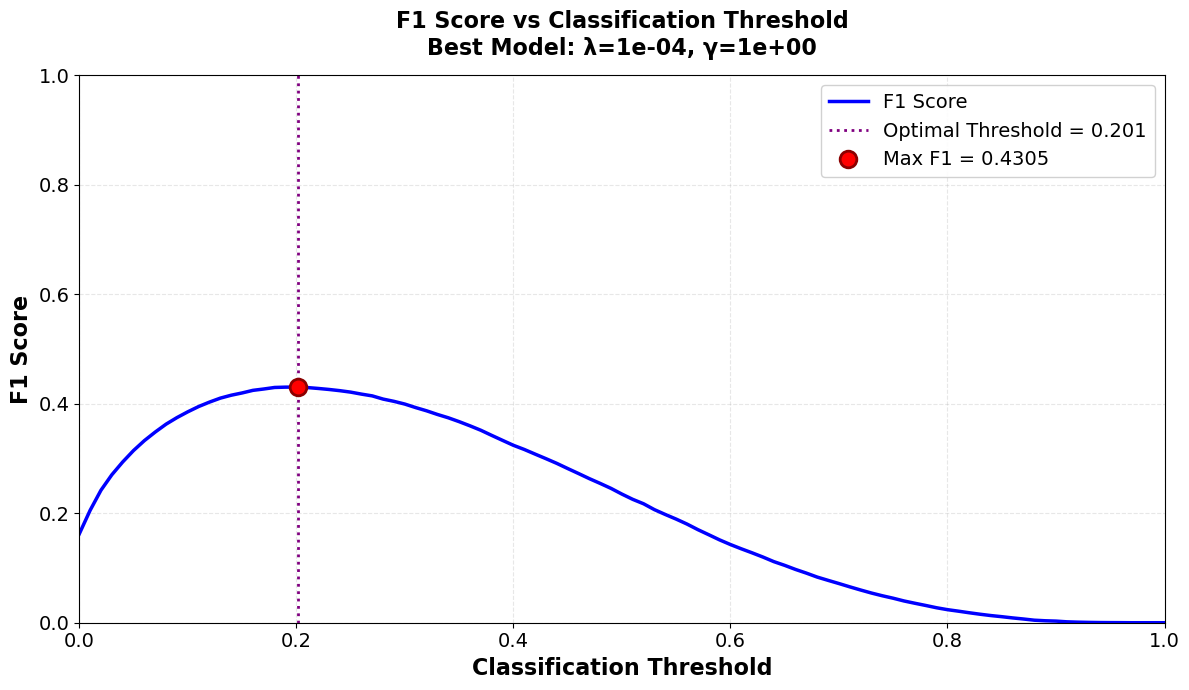


F1 Score Range: [0.0000, 0.4305]
Optimal F1 Score: 0.4305 at threshold 0.201


In [3]:
#F1 vs Selection Threshold (done on the best model - model that has the highest F1-scores)

# Find the best hyperparameter configuration
best_config = None
best_f1 = -1

for d in data:
    f1 = float(d['f1_mean'])
    if f1 > best_f1:
        best_f1 = f1
        best_config = d

print(f"Best Model Configuration:")
print(f"  Lambda: {float(best_config['lambda']):.0e}")
print(f"  Gamma: {float(best_config['gamma']):.0e}")
print(f"  Max Iters: {int(best_config['max_iters'])}")
print(f"  Optimal Threshold: {float(best_config['optimal_threshold']):.4f}")
print(f"  F1 Score: {float(best_config['f1_mean']):.4f} ± {float(best_config['f1_std']):.4f}")

# Load preprocessed data (fix path for notebook directory)
import os
preproc_path = os.path.join('..', config.PREPROC_DATA_PATH)
preproc_data = np.load(preproc_path)
X_train = preproc_data['X_train']
y_train = preproc_data['y_train']

print(f"\nTraining model with best hyperparameters...")

# Train the best model
lambda_ = float(best_config['lambda'])
gamma = float(best_config['gamma'])
max_iters = int(best_config['max_iters'])

initial_w = np.zeros(X_train.shape[1])
weights, loss = implementations.reg_logistic_regression(
    y_train, X_train, lambda_, initial_w, max_iters, gamma
)

# Get predicted probabilities
y_prob = implementations.sigmoid(X_train @ weights)

# Compute F1 scores across a range of thresholds
thresholds = np.linspace(0, 1, 101)  # 101 points from 0 to 1
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, f1 = metrics.precision_recall_f1(y_train, y_pred)
    f1_scores.append(f1)

# Plot F1 vs Threshold
fig, ax = plt.subplots(figsize=(12, 7))

# Plot F1 score
ax.plot(thresholds, f1_scores, 'b-', linewidth=2.5, label='F1 Score')

# Mark the optimal threshold
optimal_threshold = float(best_config['optimal_threshold'])
optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
optimal_f1 = f1_scores[optimal_idx]

ax.axvline(optimal_threshold, color='purple', linestyle=':', linewidth=2, 
           label=f'Optimal Threshold = {optimal_threshold:.3f}')
ax.plot(optimal_threshold, optimal_f1, 'ro', markersize=12, 
        markeredgecolor='darkred', markeredgewidth=2,
        label=f'Max F1 = {optimal_f1:.4f}')

# Formatting
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('Classification Threshold', fontsize=16, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=16, fontweight='bold')
ax.set_title(f'F1 Score vs Classification Threshold\nBest Model: λ={lambda_:.0e}, γ={gamma:.0e}', 
             fontsize=16, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=14, loc='best', framealpha=0.9)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nF1 Score Range: [{min(f1_scores):.4f}, {max(f1_scores):.4f}]")
print(f"Optimal F1 Score: {optimal_f1:.4f} at threshold {optimal_threshold:.3f}")
